In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.simplefilter("ignore")

pd.set_option('display.width', 150)

data = r'C:\Users\chris\Desktop\ML\Case\DH\RG_case_study (2).csv'

df = pd.read_csv(data)

In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                20000 non-null  int64  
 1   customer_gmv_30D_before   20000 non-null  float64
 2   customer_gmv_30D_after    20000 non-null  float64
 3   customer_gmv_120D_before  20000 non-null  float64
 4   is_non_seamless           20000 non-null  bool   
 5   non_seamless_experience   2103 non-null   object 
 6   service_experience        2103 non-null   object 
 7   country                   20000 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(3)
memory usage: 1.1+ MB
None


In [3]:
print(df.describe())

         Unnamed: 0  customer_gmv_30D_before  customer_gmv_30D_after  customer_gmv_120D_before
count  20000.000000             20000.000000            20000.000000              20000.000000
mean    4550.191450                71.261120               70.011460                285.004121
std     3032.046382                89.629716               88.194013                358.899135
min        0.000000                 0.010000                0.010000                  0.040000
25%     1660.000000                15.740000               15.500000                 62.817500
50%     4410.000000                39.780000               38.995000                158.510000
75%     7206.000000                89.110000               87.770000                356.800000
max     9999.000000               976.570000              918.320000               4022.950000


In [4]:
print(df[df.duplicated()])

Empty DataFrame
Columns: [Unnamed: 0, customer_gmv_30D_before, customer_gmv_30D_after, customer_gmv_120D_before, is_non_seamless, non_seamless_experience, service_experience, country]
Index: []


In [5]:
print(df.isna().sum())

Unnamed: 0                      0
customer_gmv_30D_before         0
customer_gmv_30D_after          0
customer_gmv_120D_before        0
is_non_seamless                 0
non_seamless_experience     17897
service_experience          17897
country                         0
dtype: int64


In [6]:
for column in df[['is_non_seamless','non_seamless_experience','service_experience','country']]:
    print(f"Unique values in {column}:")
    print(df[column].unique())
    print("-" * 50)

Unique values in is_non_seamless:
[ True False]
--------------------------------------------------
Unique values in non_seamless_experience:
['cancellation' 'short_delay' 'post_delivery_issue' 'long_delay' nan]
--------------------------------------------------
Unique values in service_experience:
['compensation' 'deflection' 'agent_chat' 'selfservice_automation' nan]
--------------------------------------------------
Unique values in country:
['TW' 'PH']
--------------------------------------------------


In [7]:
df = df.drop(columns = 'Unnamed: 0').rename(columns = {'country':'marketplace'})
df['group'] = np.where(df['is_non_seamless'] == True, "Non-Seamless", "Seamless")

print(df)

       customer_gmv_30D_before  customer_gmv_30D_after  customer_gmv_120D_before  is_non_seamless non_seamless_experience      service_experience  \
0                       155.70                  130.82                    661.20             True            cancellation            compensation   
1                       156.45                  137.51                    706.40             True             short_delay              deflection   
2                        12.28                   10.13                     44.99             True     post_delivery_issue              agent_chat   
3                        30.01                   25.52                    120.06             True     post_delivery_issue            compensation   
4                        97.12                   81.33                    399.09             True              long_delay  selfservice_automation   
...                        ...                     ...                       ...              ...         

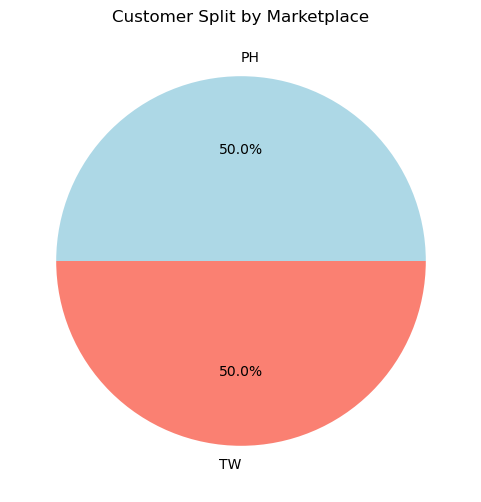

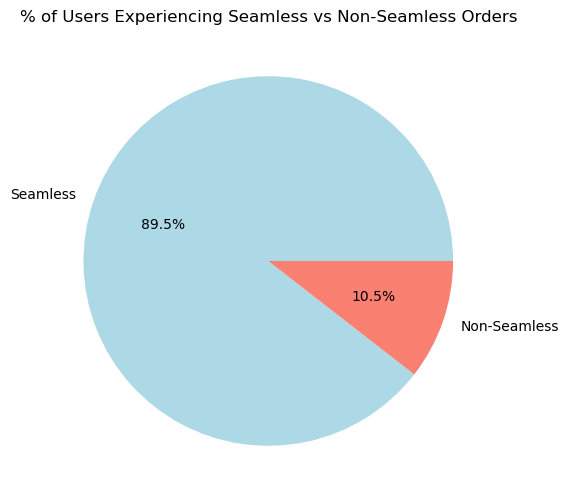

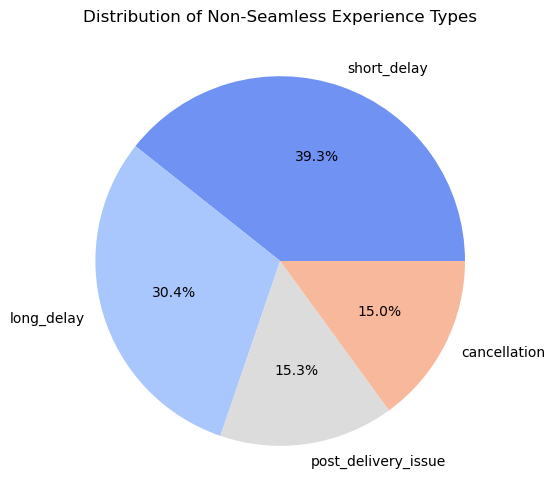

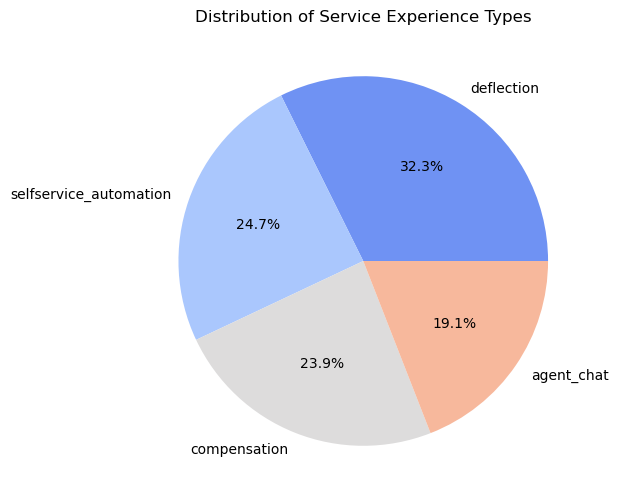

In [8]:
plt.figure(figsize=(6,6))
df['marketplace'].value_counts().plot.pie(autopct='%1.1f%%', labels=['PH', 'TW'], colors=['lightblue', 'salmon'])
plt.title("Customer Split by Marketplace")
plt.ylabel('')
plt.show()

plt.figure(figsize=(6,6))
df['is_non_seamless'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Seamless', 'Non-Seamless'], colors=['lightblue', 'salmon'])
plt.title("% of Users Experiencing Seamless vs Non-Seamless Orders")
plt.ylabel('')
plt.show()

plt.figure(figsize=(6,6))
df['non_seamless_experience'].value_counts().plot.pie(autopct='%1.1f%%', labels=df['non_seamless_experience'].value_counts().index, colors=sns.color_palette('coolwarm', len(df['non_seamless_experience'].unique())))
plt.title("Distribution of Non-Seamless Experience Types")
plt.ylabel('')
plt.show()

plt.figure(figsize=(6,6))
df['service_experience'].value_counts().plot.pie(autopct='%1.1f%%', labels=df['service_experience'].value_counts().index, colors=sns.color_palette('coolwarm', len(df['service_experience'].unique())))
plt.title("Distribution of Service Experience Types")
plt.ylabel('')
plt.show()

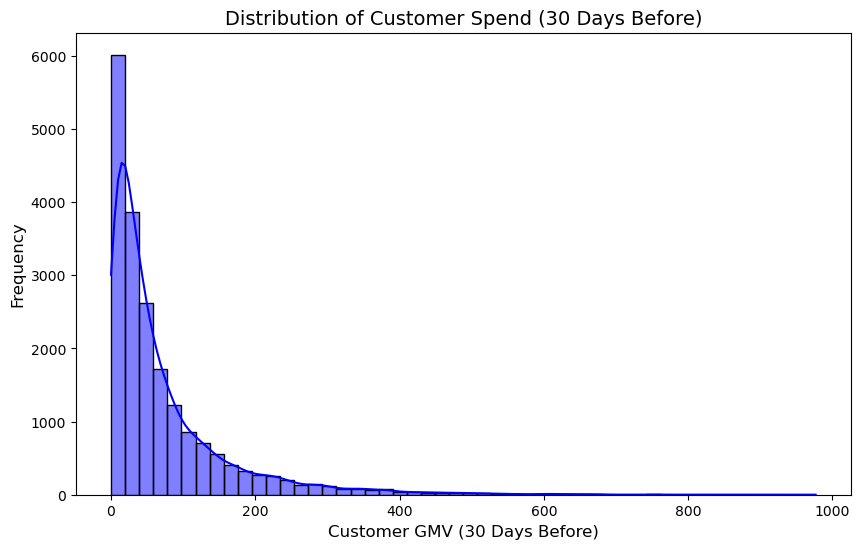

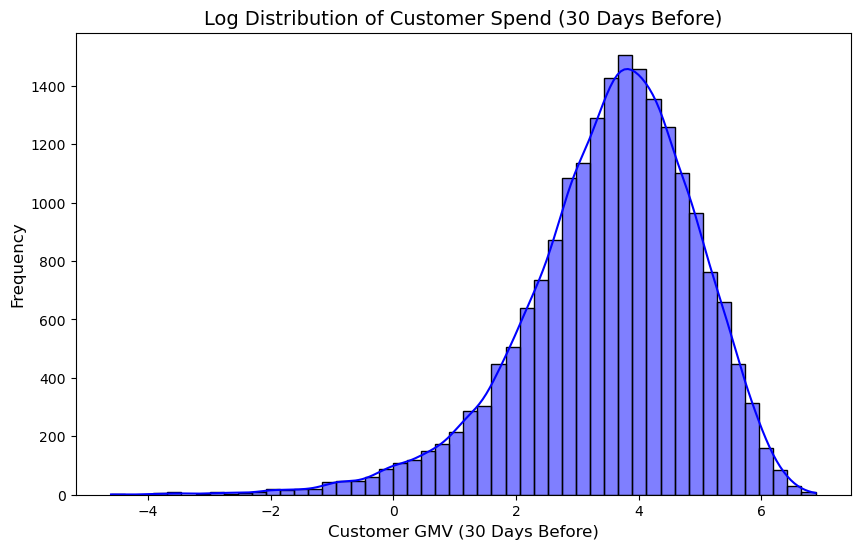

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['customer_gmv_30D_before'], bins=50, kde=True, color='blue')
plt.xlabel("Customer GMV (30 Days Before)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Customer Spend (30 Days Before)", fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(np.log(df['customer_gmv_30D_before']), bins=50, kde=True, color='blue')
plt.xlabel("Customer GMV (30 Days Before)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Log Distribution of Customer Spend (30 Days Before)", fontsize=14)
plt.show()

In [10]:
df['spend_consistency_index'] = df['customer_gmv_30D_before'] / df['customer_gmv_120D_before']

# North Start KPI: Customer Value Retention Rate, CVRR
df['CVRR'] = df['customer_gmv_30D_after'] / df['customer_gmv_30D_before']

print(df.describe())

       customer_gmv_30D_before  customer_gmv_30D_after  customer_gmv_120D_before  spend_consistency_index          CVRR
count             20000.000000            20000.000000              20000.000000             20000.000000  20000.000000
mean                 71.261120               70.011460                285.004121                 0.250593      0.984851
std                  89.629716               88.194013                358.899135                 0.012613      0.053056
min                   0.010000                0.010000                  0.040000                 0.210619      0.800000
25%                  15.740000               15.500000                 62.817500                 0.241766      0.969751
50%                  39.780000               38.995000                158.510000                 0.249976      0.995850
75%                  89.110000               87.770000                356.800000                 0.258664      1.017548
max                 976.570000          

In [11]:
# Method 1:
# Segmentation + Before & After
df_seg = df.copy()

df_seg['spend_seg'] = pd.qcut(df_seg['customer_gmv_120D_before'], q=3, labels=['Low', 'Mid', 'High'])
df_seg['spend_con_seg'] = np.where(df_seg['spend_consistency_index'] < 0.245, 'Decreased', np.where(
                            df_seg['spend_consistency_index'] > 0.255, 'Increased',
                            'Stable'
))

In [12]:
def print_results_n_significance (df, grouped_by_columns):

    print(df.groupby(grouped_by_columns + ['group']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
    ).reset_index()
    )

    results = []

    for group_vals, group_df in df.groupby(grouped_by_columns):
        
        group_key = '_'.join([str(val) for val in group_vals])
        
        seamless = group_df[group_df['group'] == 'Seamless']['CVRR']
        non_seamless = group_df[group_df['group'] == 'Non-Seamless']['CVRR']
        
        t_stat, p_val = stats.ttest_ind(seamless, non_seamless, equal_var=False)
        alpha = 0.05
        
        if p_val < alpha:
            con = "Statistically significant."
        else:
            con = "Statistically insignificant."
        
        results.append([group_key, t_stat, p_val, con])
    
    df_results = pd.DataFrame(results, columns=['group_key', 't_statistic', 'p_value', 'con'])
    
    print(df_results)

In [13]:
print_results_n_significance(df_seg, ['spend_seg','spend_con_seg'])

   spend_seg spend_con_seg         group      CVRR  count
0        Low     Decreased  Non-Seamless  0.854249    150
1        Low     Decreased      Seamless  1.000268   2028
2        Low     Increased  Non-Seamless  0.854098    212
3        Low     Increased      Seamless  0.999322   2183
4        Low        Stable  Non-Seamless  0.858416    160
5        Low        Stable      Seamless  0.999906   1934
6        Mid     Decreased  Non-Seamless  0.856355    237
7        Mid     Decreased      Seamless  0.999876   2084
8        Mid     Increased  Non-Seamless  0.854902    303
9        Mid     Increased      Seamless  0.999848   2009
10       Mid        Stable  Non-Seamless  0.855429    226
11       Mid        Stable      Seamless  1.000234   1807
12      High     Decreased  Non-Seamless  0.856374    303
13      High     Decreased      Seamless  1.000138   2096
14      High     Increased  Non-Seamless  0.860707    260
15      High     Increased      Seamless  0.999703   1955
16      High  

In [14]:
print(df.groupby(['group']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
    ).reset_index()
    )

          group      CVRR  count
0  Non-Seamless  0.856544   2103
1      Seamless  0.999928  17897


In [15]:
print(df.groupby(['non_seamless_experience']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
    ).reset_index()
    )

  non_seamless_experience      CVRR  count
0            cancellation  0.847772    315
1              long_delay  0.837574    640
2     post_delivery_issue  0.846702    321
3             short_delay  0.878385    827


In [16]:
print(df.groupby(['service_experience']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
    ).reset_index()
    )

       service_experience      CVRR  count
0              agent_chat  0.850471    401
1            compensation  0.855029    503
2              deflection  0.864708    680
3  selfservice_automation  0.852007    519


In [17]:
# print(df_seg.groupby(['spend_seg','spend_con_seg','group']).agg(
#     CVRR = ('CVRR','mean'),
#     count = ('CVRR','count')
# ).reset_index()
# )

# results = []

# for (spend_seg, spend_con_seg), group_df in df_seg.groupby(['spend_seg', 'spend_con_seg']):
    
#     seamless = group_df[group_df['group'] == 'Seamless']['CVRR']
#     non_seamless = group_df[group_df['group'] == 'Non-Seamless']['CVRR']
    
#     t_stat, p_val = stats.ttest_ind(seamless, non_seamless, equal_var=False)
#     alpha = 0.05

#     if p_value < alpha:
#         con = "Statistically significant."
#     else:
#         con = "Statistically insignificant."
    
#     results.append([spend_seg, spend_con_seg, t_stat, p_val, con])

# df_results = pd.DataFrame(results, columns=['spend_seg', 'spend_con_seg', 't_statistic', 'p_value', 'con'])

# print(df_results)

In [18]:
print(df_seg.groupby(['non_seamless_experience','service_experience']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
).reset_index())

   non_seamless_experience      service_experience      CVRR  count
0             cancellation              agent_chat  0.845789     18
1             cancellation            compensation  0.847094    146
2             cancellation              deflection  0.848137     26
3             cancellation  selfservice_automation  0.848772    125
4               long_delay              agent_chat  0.837602    136
5               long_delay            compensation  0.837148    127
6               long_delay              deflection  0.837497    174
7               long_delay  selfservice_automation  0.837889    203
8      post_delivery_issue              agent_chat  0.846508    162
9      post_delivery_issue            compensation  0.848864     67
10     post_delivery_issue              deflection  0.846281     41
11     post_delivery_issue  selfservice_automation  0.844819     51
12             short_delay              agent_chat  0.879605     85
13             short_delay            compensati

In [19]:
print(df_seg.groupby(['marketplace','spend_seg','spend_con_seg','non_seamless_experience','service_experience']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
).reset_index())

    marketplace spend_seg spend_con_seg non_seamless_experience      service_experience      CVRR  count
0            PH       Low     Decreased            cancellation              agent_chat       NaN      0
1            PH       Low     Decreased            cancellation            compensation  0.838452      3
2            PH       Low     Decreased            cancellation              deflection       NaN      0
3            PH       Low     Decreased            cancellation  selfservice_automation  0.832341      3
4            PH       Low     Decreased              long_delay              agent_chat  0.828398      2
..          ...       ...           ...                     ...                     ...       ...    ...
283          TW      High        Stable     post_delivery_issue  selfservice_automation  0.853583      5
284          TW      High        Stable             short_delay              agent_chat  0.882350      8
285          TW      High        Stable             sho

In [20]:
for x in ['PH','TW']:
    print(x)
    print(df_seg[df_seg['marketplace'] == x].groupby(['non_seamless_experience','service_experience']).agg(
        CVRR = ('CVRR','mean'),
        count = ('CVRR','count')
    ).reset_index())

PH
   non_seamless_experience      service_experience      CVRR  count
0             cancellation              agent_chat  0.821712      4
1             cancellation            compensation  0.837640     25
2             cancellation              deflection  0.831289      6
3             cancellation  selfservice_automation  0.835530     21
4               long_delay              agent_chat  0.825231     30
5               long_delay            compensation  0.825198     28
6               long_delay              deflection  0.825218     29
7               long_delay  selfservice_automation  0.820376     27
8      post_delivery_issue              agent_chat  0.834111     27
9      post_delivery_issue            compensation  0.841155     13
10     post_delivery_issue              deflection  0.833566      7
11     post_delivery_issue  selfservice_automation  0.831507     11
12             short_delay              agent_chat  0.868457     14
13             short_delay            compens

In [21]:
# Method 2:
# PSM
matching_vars = ['customer_gmv_120D_before', 'customer_gmv_30D_before', 'marketplace']  
X = pd.get_dummies(df[matching_vars], drop_first=True) 
y = df_seg['is_non_seamless']

model = LogisticRegression()
model.fit(X, y)

df_seg['propensity_score'] = model.predict_proba(X)[:, 1]

seamless = df_seg[df_seg['group'] == 'Seamless']
nonseamless = df_seg[df_seg['group'] == 'Non-Seamless']

neighbors = NearestNeighbors(n_neighbors=1)

neighbors.fit(seamless[['propensity_score']])
distances_1, indices_1 = neighbors.kneighbors(nonseamless[['propensity_score']])

seamless_matched = seamless.iloc[indices_1.flatten()]

df_matched = pd.concat([seamless_matched, nonseamless])
print(f"Number of matched rows: {len(df_matched)}")

Number of matched rows: 4206


In [22]:
effect_size = 0.3
alpha = 0.05       
power = 0.9        

power_analysis = TTestIndPower()
required_n = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1.0)

print(f"Required sample size per group: {int(required_n)}")
print(f"Total required sample size: {int(required_n * 2)}")

Required sample size per group: 234
Total required sample size: 468


In [23]:
print_results_n_significance(df_matched, ['spend_seg','spend_con_seg'])

   spend_seg spend_con_seg         group      CVRR  count
0        Low     Decreased  Non-Seamless  0.854249    150
1        Low     Decreased      Seamless  1.001550    151
2        Low     Increased  Non-Seamless  0.854098    212
3        Low     Increased      Seamless  0.996519    212
4        Low        Stable  Non-Seamless  0.858416    160
5        Low        Stable      Seamless  1.001279    158
6        Mid     Decreased  Non-Seamless  0.856355    237
7        Mid     Decreased      Seamless  1.000541    253
8        Mid     Increased  Non-Seamless  0.854902    303
9        Mid     Increased      Seamless  0.997571    278
10       Mid        Stable  Non-Seamless  0.855429    226
11       Mid        Stable      Seamless  0.999946    229
12      High     Decreased  Non-Seamless  0.856374    303
13      High     Decreased      Seamless  1.002751    286
14      High     Increased  Non-Seamless  0.860707    260
15      High     Increased      Seamless  1.001264    273
16      High  

In [24]:
print(df_matched.groupby(['marketplace','spend_seg','spend_con_seg','non_seamless_experience','service_experience']).agg(
    CVRR = ('CVRR','mean'),
    count = ('CVRR','count')
).reset_index())

    marketplace spend_seg spend_con_seg non_seamless_experience      service_experience      CVRR  count
0            PH       Low     Decreased            cancellation              agent_chat       NaN      0
1            PH       Low     Decreased            cancellation            compensation  0.838452      3
2            PH       Low     Decreased            cancellation              deflection       NaN      0
3            PH       Low     Decreased            cancellation  selfservice_automation  0.832341      3
4            PH       Low     Decreased              long_delay              agent_chat  0.828398      2
..          ...       ...           ...                     ...                     ...       ...    ...
283          TW      High        Stable     post_delivery_issue  selfservice_automation  0.853583      5
284          TW      High        Stable             short_delay              agent_chat  0.882350      8
285          TW      High        Stable             sho

In [25]:
# Method 3:
# OLS Regression

df_ns = df_seg[df_seg['group'] == 'Non-Seamless']

df_ns['spend_seg'] = pd.Categorical(df_ns['spend_seg'], categories=['Mid', 'High', 'Low'], ordered=True)
df_ns['spend_con_seg'] = pd.Categorical(df_ns['spend_con_seg'], categories=['Stable', 'Increased','Decreased'], ordered=True)
df_ns['non_seamless_experience'] = pd.Categorical(df_ns['non_seamless_experience'], categories=['short_delay', 'long_delay', 'post_delivery_issue','cancellation'], ordered=True)
df_ns['service_experience'] = pd.Categorical(df_ns['service_experience'], categories=['deflection', 'selfservice_automation', 'agent_chat', 'compensation'], ordered=True)

df_encoded = pd.get_dummies(df_ns, columns=['spend_seg','spend_con_seg','non_seamless_experience','service_experience', 'marketplace'], drop_first=True)
dummy_cols = [col for col in df_encoded if col not in df_ns]

df_encoded['log_customer_gmv_120D_before'] = np.log(df_encoded['customer_gmv_120D_before'])

X = df_encoded[['log_customer_gmv_120D_before'] + dummy_cols].astype(float)

y = df_encoded['CVRR']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(model.summary())
print("\n\n")
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:                   CVRR   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     580.4
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:51:07   Log-Likelihood:                 6636.3
No. Observations:                2103   AIC:                        -1.325e+04
Df Residuals:                    2090   BIC:                        -1.317e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [26]:
interaction_terms = []
for service_col in ['service_experience_selfservice_automation', 'service_experience_agent_chat', 'service_experience_compensation']:
    for experience_col in ['non_seamless_experience_long_delay', 'non_seamless_experience_post_delivery_issue', 'non_seamless_experience_cancellation']:
        interaction_term_name = f"{service_col}_x_{experience_col}"

        df_encoded[interaction_term_name] = df_encoded[service_col] * df_encoded[experience_col]
        interaction_terms.append(interaction_term_name)

X = df_encoded[['log_customer_gmv_120D_before'] + dummy_cols + interaction_terms].astype(float)

y = df_encoded['CVRR']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(model.summary())
print("\n\n")
print(vif_data)


                            OLS Regression Results                            
Dep. Variable:                   CVRR   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     332.1
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:51:07   Log-Likelihood:                 6640.8
No. Observations:                2103   AIC:                        -1.324e+04
Df Residuals:                    2081   BIC:                        -1.311e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [27]:
for x in ['TW','PH']:

    df_c = df_ns[df_ns['marketplace'] == x]

    df_x = pd.get_dummies(df_c, columns=['spend_seg','spend_con_seg','non_seamless_experience','service_experience'], drop_first=True)
    dummy_cols = [col for col in df_x if col not in df_c]
    
    df_x['log_customer_gmv_120D_before'] = np.log(df_x['customer_gmv_120D_before'])
    
    X = df_x[['log_customer_gmv_120D_before'] + dummy_cols].astype(float)
    
    y = df_x['CVRR']
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    print(x, "\n\n", model.summary())

TW 

                             OLS Regression Results                            
Dep. Variable:                   CVRR   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     459.3
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:51:08   Log-Likelihood:                 5445.0
No. Observations:                1726   AIC:                        -1.087e+04
Df Residuals:                    1714   BIC:                        -1.080e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [28]:
for x in ['TW','PH']:

    interaction_terms = []
    
    for service_col in ['service_experience_selfservice_automation', 'service_experience_agent_chat', 'service_experience_compensation']:
        for experience_col in ['non_seamless_experience_long_delay', 'non_seamless_experience_post_delivery_issue', 'non_seamless_experience_cancellation']:
            interaction_term_name = f"{service_col}_x_{experience_col}"
    
            df_x[interaction_term_name] = df_x[service_col] * df_x[experience_col]
            interaction_terms.append(interaction_term_name)
    
    X = df_x[['log_customer_gmv_120D_before'] + dummy_cols + interaction_terms].astype(float)
    
    y = df_x['CVRR']
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    print(x, "\n\n", model.summary())

TW 

                             OLS Regression Results                            
Dep. Variable:                   CVRR   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     69.97
Date:                Sun, 30 Mar 2025   Prob (F-statistic):          3.84e-110
Time:                        22:51:08   Log-Likelihood:                 1207.4
No. Observations:                 377   AIC:                            -2373.
Df Residuals:                     356   BIC:                            -2290.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------